In [1]:
import sys
sys.path.append('../scripts/')
from ideal_robot import *
matplotlib.use('nbagg')

In [8]:
class Goal(Landmark):
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="+", label="Goal", color="green")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "Goal id:" + str(self.id), fontsize=12))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [22]:
class Agent_DWA(Agent):
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        # DW
        self.max_nu = 0.5
        self.min_nu = 0.3
        self.max_omega = 30.0/180.0*math.pi
        self.min_omega = -30.0/180.0*math.pi
        self.delta_nu = 0.05
        self.delta_omega = 5.0/180.0*math.pi
        # 評価関数の係数
        self.to_goal_cost_gain = 0.5
        self.speed_cost_gain = 1.5
        self.obstacle_cost_gain = 1.6
        # ロボット半径
        self.robot_radius = 0.2
        
        
    def decision(self, observation, pos, time_interval):
        if observation == None: return self.nu, self.omega
        
        max_score = 0
        score_sum = 0.0
        scores = []
        
        for omega in np.arange(self.min_omega, self.max_omega, self.delta_omega):
            for nu in np.arange(self.min_nu, self.max_nu, self.delta_nu):
                current_score = self.score(nu, omega, observation, pos, time_interval)
                if current_score == 0.0: # ゴールしたら 
                    self.nu = 0.0
                    self.omega = 0.0
                score_sum = score_sum + current_score
                if max_score < current_score:
                    max_score = current_score
                    self.nu = nu
                    self.omega = omega
            scores.append(score_sum)
            score_sum = 0.0
            
        print(scores)
        
        return self.nu, self.omega
    
    def score(self, nu, omega, observation, last_pose, time_interval):
        pose = IdealRobot.state_transition(nu, omega, 2.0, last_pose)
        dis_min  = 10000000000.0
        dis = 0.0
        heading = 0.0
        for obs in observation:
            if obs[1].id == 100:
                heading = (IdealCamera.observation_function(pose, obs[1].pos))[1]
                if self.robot_radius > (IdealCamera.observation_function(last_pose, obs[1].pos))[0]:
                    return 0.0
            else:
                dis = (IdealCamera.observation_function(pose, obs[1].pos))[0]
                if dis_min > dis:
                    dis_min = dis
        return self.speed_cost_gain*nu + self.obstacle_cost_gain*dis_min + self.to_goal_cost_gain*(math.pi - abs(heading))
    
    def draw(self, ax, elems, pos):
        elems.append(ax.text(pos[0]+0.5, pos[1]+0.5, str(self.nu) + " " + str(self.omega), fontsize=10))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

<IPython.core.display.Javascript object>


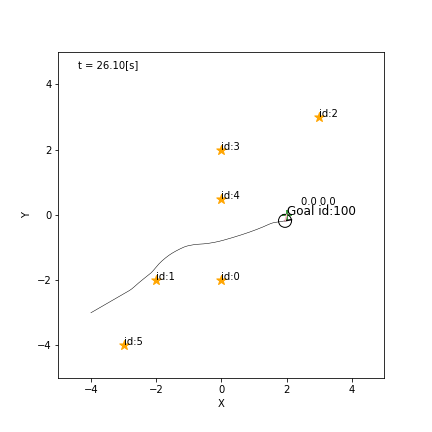

In [31]:
world = World(90, 0.1, debug=False) 

### 地図を生成して3つランドマークを追加 ###
m = Map()                                  
m.append_landmark(Landmark(0,-2), g=False)
m.append_landmark(Landmark(-2,-2), g=False)
m.append_landmark(Landmark(3,3), g=False)
m.append_landmark(Landmark(0,2), g=False)
m.append_landmark(Landmark(0,0.5), g=False)
m.append_landmark(Landmark(-3,-4), g=False)
goal = Goal(2,0)
m.append_landmark(goal, g=True)
world.append(m)          

### ロボットを作る ###
agent_dwa = Agent_DWA(0.0, 0.0)
robot1 = IdealRobot( np.array([ -4,-3, math.pi/6]).T, sensor=IdealCamera(m), agent=agent_dwa, goal=goal)
world.append(robot1)

### アニメーション実行 ###
world.draw()